# novedad_shell
## El propósito de este notebook es presentar una metodología de extracción de "novedades", basada en la descomposición $k-shell$. Las redes de palabras correspondientes a cada año (entre 2010 y 2016) se descomponen en $k-shells$, las cuales son agrupadas en $K=90$ capas que permiten la comparación a lo largo de los distintos años. Así, describimos la evolución de cada capa en el tiempo. El análisis está basado en la comparación entre la cantidad total de palabras acumuladas (es decir, miramos los nodos involucrados en una capa y vemos en el texto la frecuencia de aparición de estos nodos (palabras)) y la cantidad acumulada de palabras distintas. La hipótesis que subyace a este análisis es que las "novedades" aparecerán en las capas más externas de los grafos, dejando las capas internas (cercanas al $k_{max}-core$) como la parte más estable de los grafos, y por lo tanto de las revistas. 


In [177]:
import matplotlib.pyplot as plt
import networkx as nx
from nltk import sent_tokenize
from nltk import word_tokenize
import numpy as np
import re
import pickle
import string
import operator
import itertools
import community
import json
import statistics
from collections import Counter
from collections import Counter

In [178]:
#########################################################################################################################
############################################### progress bar ############################################################
#########################################################################################################################
################################# https://github.com/alexanderkuk/log-progress ##########################################
#########################################################################################################################
def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )
#########################################################################################################################
#########################################################################################################################
#########################################################################################################################

## Descripción de los grafos por año
### Los grafos están construidos utilizando únicamente sustantivos (comunes y propios) y con co-ocurrencia dentro de una oración. Se utilizaron 2080 introducciones de la revista Cell.

### cell

In [179]:
keys_doi=['2010','2011','2012','2013','2014','2015','2016']

In [180]:
graphs_cell = pickle.load(open( 'graphs_cell.p', 'rb' ) )

In [181]:
for key in keys_doi:
    G=graphs_cell[key]
    print(key)
    print('nodes: '+str(len(G.nodes)))
    print('edges: '+str(len(G.edges)))
    print('average degree: '+str(sum(dict(nx.degree(G,weight='weight')).values())/float(len(G.nodes))))
    print('max degree: '+str(max(dict(nx.degree(G,weight='weight')).values())))
    core_number=nx.core_number(G)
    print('max core number: '+str(max(core_number.values())))
    main_core=nx.k_core(G,max(core_number.values()))
    print('main core size: '+str(len(main_core)))
    main_crust=nx.k_crust(G,max(core_number.values())-1)
    print('main crust size: '+str(len(main_crust)))

2010
nodes: 9382
edges: 232997
average degree: 5.62332125346408
max degree: 525.9999999999999
max core number: 89
main core size: 289
main crust size: 9093
2011
nodes: 10221
edges: 277270
average degree: 6.0851188729087164
max degree: 660.0000000000008
max core number: 101
main core size: 291
main crust size: 9930
2012
nodes: 11901
edges: 347888
average degree: 6.7948071590622625
max degree: 842.0000000000076
max core number: 119
main core size: 333
main crust size: 11568
2013
nodes: 11551
edges: 328830
average degree: 6.6130205177040935
max degree: 784.0000000000051
max core number: 112
main core size: 376
main crust size: 11175
2014
nodes: 11871
edges: 352073
average degree: 6.761856625389606
max degree: 849.0000000000073
max core number: 119
main core size: 378
main crust size: 11493
2015
nodes: 12962
edges: 381724
average degree: 6.533945378799568
max degree: 905.0000000000059
max core number: 120
main core size: 335
main crust size: 12627
2016
nodes: 11573
edges: 333336
average de

## k shell decomposition by year

### cell

In [182]:
decomposition_shell_cell={}
for key in log_progress(keys_doi, every=1):
    G=graphs_cell[key]
    core_numbers=list(set(nx.core_number(G).values()))
    dict_shell={}
    for k in core_numbers:
        dict_shell[k]=nx.k_shell(G,k)
    decomposition_shell_cell[key]=dict_shell

In [183]:
pickle.dump(decomposition_shell_cell,open('decomposition_shell_cell.p','wb'))

### shell decomposition

In [184]:
decomposition_shell_cell = pickle.load(open('decomposition_shell_cell.p', 'rb')) ## solo para el 2016
text_cell = pickle.load(open( 'text_cell.p', 'rb' ) )

In [185]:
def NTvsT(decomposition,words_text,graphs): 
    cumulated_words_core=[]
    words_dict_core={}
    
    for k in sorted(decomposition.keys()):
        words=words_text[k]
        core_words=list(decomposition[k].nodes())
        
        words=[item for sublist in words for item in sublist if item in core_words]
        cumulated_words_core+=words
        
        total_words=len(cumulated_words_core)
        total_diff=len(list(set(cumulated_words_core)))
        largest = max(nx.connected_components(decomposition[k]), key=len)
        cc=np.mean(list(nx.clustering(graphs[k],nodes=core_words,weight='weight').values()))
        words_dict_core[k]=[total_words,total_diff,len(core_words),nx.number_connected_components(decomposition[k]),len(largest),len(largest)/float(len(decomposition[k])),cc]
    
    return words_dict_core

In [186]:
def NnewvsT(decomposition,words_text,graphs): 
    cumulated_words_core=[]
    words_dict_core={}
    
    for k in sorted(decomposition.keys()):
        words=words_text[k]
        core_words=list(decomposition[k].nodes())
        
        words=[item for sublist in words for item in sublist if item in core_words]
        cumulated_words_core_copy=cumulated_words_core.copy()
        cumulated_words_core+=words
        
        total_words=len(cumulated_words_core)
        total_diff=len(list(set(cumulated_words_core)))
        total_new=len(list(set(cumulated_words_core)-set(cumulated_words_core_copy)))
        
        words_dict_core[k]=[total_words,total_new,total_diff,len(core_words)]
    
    return words_dict_core

In [187]:
for key in decomposition_shell_cell.keys():
    seq=list(decomposition_shell_cell[key].keys())
    pieces = 50
    m = float(len(seq))/pieces
    seq_of_seqs=[seq[int(m*i):int(m*(i+1))] for i in range(pieces)]
    S=[]
    for L in seq_of_seqs:
        L=[decomposition_shell_cell[key][i] for i in L]
        S+=[nx.union_all(L)]
    decomposition_shell_cell[key]=S

In [188]:
list_by_year=list(zip(*list(decomposition_shell_cell.values())))

In [189]:
data=[]
for item in list_by_year:
    item={x:y for x,y in zip(decomposition_shell_cell.keys(),item)}
    data+=[item]

In [190]:
for i in log_progress(range(len(data)),every=1):
    data[i]=NTvsT(data[i],text_cell,graphs_cell)

In [191]:
data_new=[]
for item in list_by_year:
    item={x:y for x,y in zip(decomposition_shell_cell.keys(),item)}
    data_new+=[item]

In [192]:
for i in log_progress(range(len(data_new)),every=1):
    data_new[i]=NnewvsT(data_new[i],text_cell,graphs_cell)

In [193]:
data_2016=[item['2016'] for item in data]

In [194]:
data_2016_new=[item['2016'] for item in data_new]

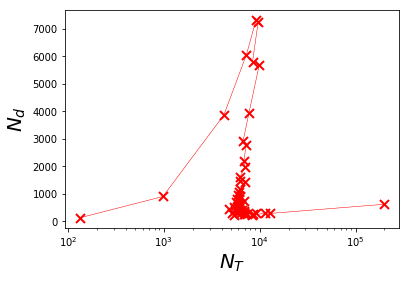

In [195]:
plt.semilogx(list(list(zip(*data_2016))[0]),list(list(zip(*data_2016))[1]),'r',marker='x',markersize=9,fillstyle='none',markeredgewidth=2,clip_on=False,linewidth=0.5)

plt.ylabel(r'$N_d$',fontsize=20)
plt.xlabel(r'$N_T$',fontsize=20)
plt.rcParams.update({'font.size': 10})
plt.savefig('Nd_NT.pdf', format='pdf', transparent=True, bbox_inches='tight',dpi=1000)
plt.show()

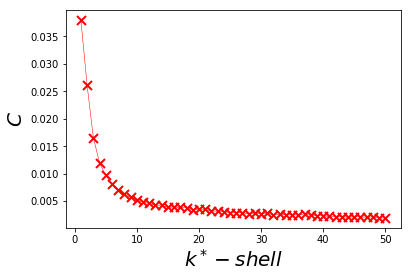

In [196]:
plt.plot(range(1,51),list(list(zip(*data_2016))[6]),'r',marker='x',markersize=9,fillstyle='none',markeredgewidth=2,clip_on=False,linewidth=0.5)

plt.ylabel(r'$C$',fontsize=20)
plt.xlabel(r'$k^*-shell$',fontsize=20)
plt.rcParams.update({'font.size': 10})
plt.savefig('cc_k*shell.pdf', format='pdf', transparent=True, bbox_inches='tight',dpi=1000)
plt.show()

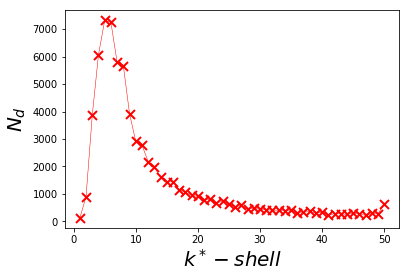

In [198]:
plt.plot(range(1,51),list(list(zip(*data_2016))[1]),'r',marker='x',markersize=9,fillstyle='none',markeredgewidth=2,clip_on=False,linewidth=0.5)

plt.ylabel(r'$N_d$',fontsize=20)
plt.xlabel(r'$k^*-shell$',fontsize=20)
plt.rcParams.update({'font.size': 10})
plt.savefig('Nd_k*shell.pdf', format='pdf', transparent=True, bbox_inches='tight',dpi=1000)
plt.show()

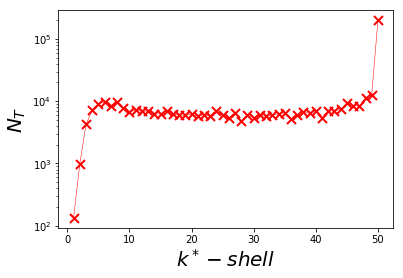

In [199]:
plt.semilogy(range(1,51),list(list(zip(*data_2016))[0]),'r',marker='x',markersize=9,fillstyle='none',markeredgewidth=2,clip_on=False,linewidth=0.5)

plt.ylabel(r'$N_T$',fontsize=20)
plt.xlabel(r'$k^*-shell$',fontsize=20)
plt.rcParams.update({'font.size': 10})
plt.savefig('NT_k*shell.pdf', format='pdf', transparent=True, bbox_inches='tight',dpi=1000)
plt.show()

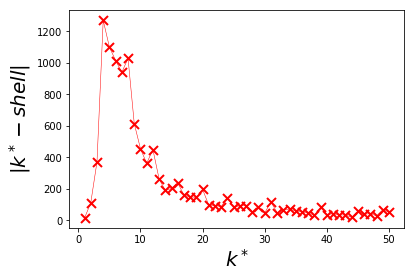

In [200]:
plt.plot(range(1,51),list(list(zip(*data_2016))[2]),'r',marker='x',markersize=9,fillstyle='none',markeredgewidth=2,clip_on=False,linewidth=0.5)

plt.ylabel(r'$|k^*-shell|$',fontsize=20)
plt.xlabel(r'$k^*$',fontsize=20)
plt.rcParams.update({'font.size': 10})
plt.savefig('k*shell_size.pdf', format='pdf', transparent=True, bbox_inches='tight',dpi=1000)
plt.show()

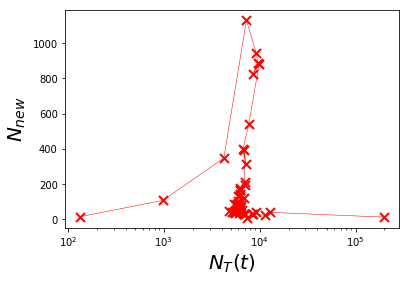

In [201]:
plt.semilogx(list(list(zip(*data_2016_new))[0]),list(list(zip(*data_2016_new))[1]),'r',marker='x',markersize=9,fillstyle='none',markeredgewidth=2,clip_on=False,linewidth=0.5)

plt.ylabel(r'$N_{new}$',fontsize=20)
plt.xlabel(r'$N_T(t)$',fontsize=20)
plt.rcParams.update({'font.size': 10})
plt.savefig('Nnew_NT.pdf', format='pdf', transparent=True, bbox_inches='tight',dpi=1000)
plt.show()

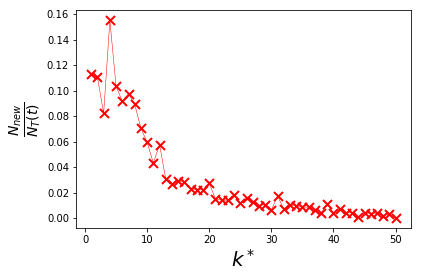

In [202]:
plt.plot(range(1,51),[x/float(y) for x,y in zip(list(list(zip(*data_2016_new))[1]),list(list(zip(*data_2016_new))[0]))],'r',marker='x',markersize=9,fillstyle='none',markeredgewidth=2,clip_on=False,linewidth=0.5)

plt.ylabel(r'$\frac{N_{new}}{N_T(t)}$',fontsize=20)
plt.xlabel(r'$k^*$',fontsize=20)
plt.rcParams.update({'font.size': 10})
#plt.savefig('Nnewvst_shell_cell.pdf', format='pdf', transparent=True, bbox_inches='tight',dpi=1000)
plt.show()

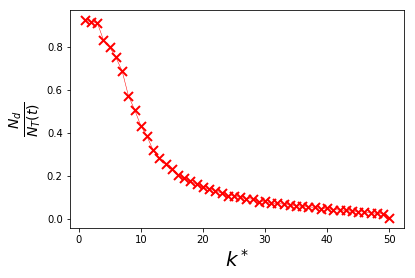

In [203]:
plt.plot(range(1,51),[x/float(y) for x,y in zip(list(list(zip(*data_2016_new))[2]),list(list(zip(*data_2016_new))[0]))],'r',marker='x',markersize=9,fillstyle='none',markeredgewidth=2,clip_on=False,linewidth=0.5)

plt.ylabel(r'$\frac{N_d}{N_T(t)}$',fontsize=20)
plt.xlabel(r'$k^*$',fontsize=20)
plt.rcParams.update({'font.size': 10})
#plt.savefig('Nnewvst_shell_cell.pdf', format='pdf', transparent=True, bbox_inches='tight',dpi=1000)
plt.show()

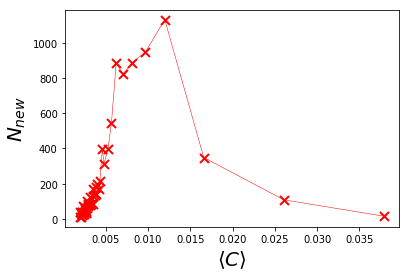

In [204]:
plt.plot(list(list(zip(*data_2016))[6]),list(list(zip(*data_2016_new))[1]),'r',marker='x',markersize=9,fillstyle='none',markeredgewidth=2,clip_on=False,linewidth=0.5)

plt.ylabel(r'$N_{new}$',fontsize=20)
plt.xlabel(r'$\langle C \rangle$',fontsize=20)
plt.rcParams.update({'font.size': 10})
#plt.savefig('Nnewvst_shell_cell.pdf', format='pdf', transparent=True, bbox_inches='tight',dpi=1000)
plt.show()

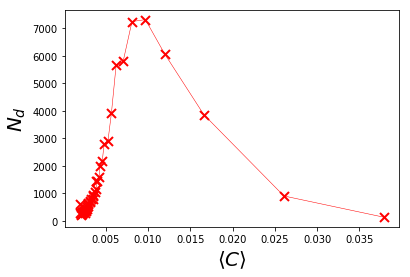

In [205]:
plt.plot(list(list(zip(*data_2016))[6]),list(list(zip(*data_2016))[1]),'r',marker='x',markersize=9,fillstyle='none',markeredgewidth=2,clip_on=False,linewidth=0.5)

plt.ylabel(r'$N_d$',fontsize=20)
plt.xlabel(r'$\langle C \rangle$',fontsize=20)
plt.rcParams.update({'font.size': 10})
#plt.savefig('Nnewvst_shell_cell.pdf', format='pdf', transparent=True, bbox_inches='tight',dpi=1000)
plt.show()